In [5]:
# Get the data
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

--2024-11-18 12:35:54--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.207, 173.194.217.207, 108.177.11.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.5’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2024-11-18 12:35:54 (104 MB/s) - ‘nlp_getting_started.zip.5’ saved [607343/607343]



In [6]:
import zipfile
zip_ref = zipfile.ZipFile("/content/nlp_getting_started.zip")
zip_ref.extractall()
zip_ref.close()

In [7]:
import pandas as pd
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train_df.target.value_counts()

,count
target,
0,4342
1,3271




*   1 = a real disaster Tweet
*   0 = not a real disaster Tweet




In [10]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [11]:
# Shuffle the train_df
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [12]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
'Up' House Saved From Demolition - http://t.co/4CPNBBZkzg Will be moved to Orcas Island Washington.

---

Target: 0 (not real disaster)
Text:
It hurts for me to eat cause i burned my tounge with a pepperoni yesterday!

---

Target: 0 (not real disaster)
Text:
What's wrong with just a lil smoke and good conversation ????

---

Target: 0 (not real disaster)
Text:
@JustinTrudeau 

Most respected in world
Best job recovery G7 and G20
Best led during 2008 world meltdown

What exactly have you done ??

---

Target: 0 (not real disaster)
Text:
@Stretcher @Rexyy @invalid @Towel let's have babies??!

---



In [13]:
# Split the data into train, val ds
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
train_sentences[:4], train_labels[:4]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet"],
       dtype=object),
 array([0, 0, 1, 0]))

## Converting text into tensors

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None)

In [16]:
# Find average number of tokens (words) in trainig Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
from tensorflow.keras.layers import TextVectorization

max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [18]:
text_vectorizer.adapt(train_sentences)

In [19]:
sample_sentence = "I love playing games"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   8,  110,  930, 1407,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [20]:
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
*screams internally*      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 476, 1280,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [21]:
# Get the unique words in vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [22]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding

embedding = Embedding(input_dim = max_vocab_length,
                      output_dim = 128,
                      embeddings_initializer = 'uniform',
                      input_length = max_length,
                      name = "embedding_1")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
embedding

<Embedding name=embedding_1, built=False>

In [24]:

# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Metal Cutting Sparks Brush Fire In Brighton: A brush fire that was sparked by a landowner cutting metal burned 10Û_ http://t.co/rj7m42AtWS      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01199404, -0.03783246,  0.04606335, ...,  0.04781177,
         -0.00560592,  0.01439619],
        [ 0.0025924 ,  0.00357167,  0.00797416, ..., -0.01505834,
         -0.04805139,  0.02863051],
        [ 0.03183744, -0.00019448, -0.03961138, ..., -0.00435431,
         -0.04244783, -0.00940078],
        ...,
        [ 0.04122921,  0.03533597,  0.00045156, ..., -0.03648617,
         -0.04662106, -0.04754151],
        [-0.0188025 , -0.02317091, -0.02026233, ...,  0.01995737,
          0.04873829,  0.01829535],
        [ 0.02243699,  0.03115523, -0.01490066, ..., -0.04142516,
         -0.04561051,  0.03539404]]], dtype=float32)>

In [25]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.01199404, -0.03783246,  0.04606335, -0.02682252, -0.04652045,
       -0.02381188,  0.01890676,  0.01054887,  0.04748256, -0.03060327,
       -0.00765828, -0.01633353,  0.01908496, -0.03569344,  0.02270797,
        0.0387441 , -0.03551397,  0.01564813, -0.02617229,  0.02802197,
        0.01119374, -0.00705032, -0.02375925,  0.04436949, -0.01006745,
        0.02000059,  0.0057543 , -0.0469466 ,  0.04247892, -0.01355378,
        0.03856735,  0.0230403 ,  0.03534095,  0.01073706,  0.01405982,
       -0.03865421, -0.00388994, -0.04694787,  0.04309416, -0.03693597,
        0.03189068, -0.03477827, -0.00049795, -0.04587736,  0.04284999,
       -0.01841478, -0.00921077, -0.02012306,  0.033485  , -0.00398781,
       -0.04791544,  0.01566945, -0.01210641,  0.04223541, -0.03697814,
       -0.04013569, -0.00622456, -0.04876388,  0.04463041, -0.01543472,
       -0.01566052,  0.02474506, -0.02215442, -0.02321699,  0.00523382,
       -0.031943

# Build a Model

## Naive Base Model 0

In [26]:
# Model_0 baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model_0 = make_pipeline(TfidfVectorizer(), # convert words to numbers using Tfidf
                        MultinomialNB()) # model the text

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [27]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [28]:
# make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [31]:
def calculate_results(y_true, y_pred):
    """
    Calculates model metrics.

    Args:
        y_true: True labels.
        y_pred: Predicted labels.

    Returns:
        A dictionary containing the calculated metrics.
    """
    # Import necessary modules
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    # Create a dictionary of results
    results = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

    return results

def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [32]:
baseline_results = calculate_results(y_true=val_labels,
                                  y_pred=baseline_preds)
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1 A simple dense Model

In [33]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [34]:
# Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
# Get the summary of the model
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Model Checkpoints callback
model_check_pt = tf.keras.callbacks.ModelCheckpoint("./data/model_checkpoint.keras",
                                  monitor='val_loss',
                                  verbose=0,
                                  save_best_only=False,
                                  save_weights_only=False,
                                  mode='auto',
                                  save_freq='epoch',
                                  initial_value_threshold=None)

In [37]:
# Fit the model
history_1 = model_1.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[model_check_pt])

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6461 - loss: 0.6485 - val_accuracy: 0.7507 - val_loss: 0.5359
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8208 - loss: 0.4570 - val_accuracy: 0.7835 - val_loss: 0.4720
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8536 - loss: 0.3634 - val_accuracy: 0.7861 - val_loss: 0.4618
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8896 - loss: 0.2888 - val_accuracy: 0.7913 - val_loss: 0.4665
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9077 - loss: 0.2511 - val_accuracy: 0.7874 - val_loss: 0.4867


<Axes: >

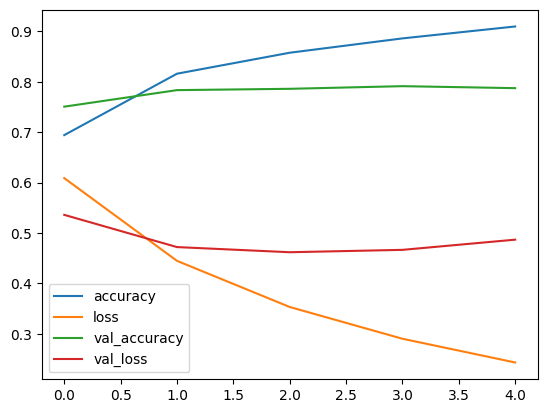

In [38]:
import pandas as pd
pd.DataFrame(history_1.history).plot()

In [39]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)

  plt.plot(epochs, val_loss, label="val_loss")
  plt.plot(epochs, val_acc, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.show()

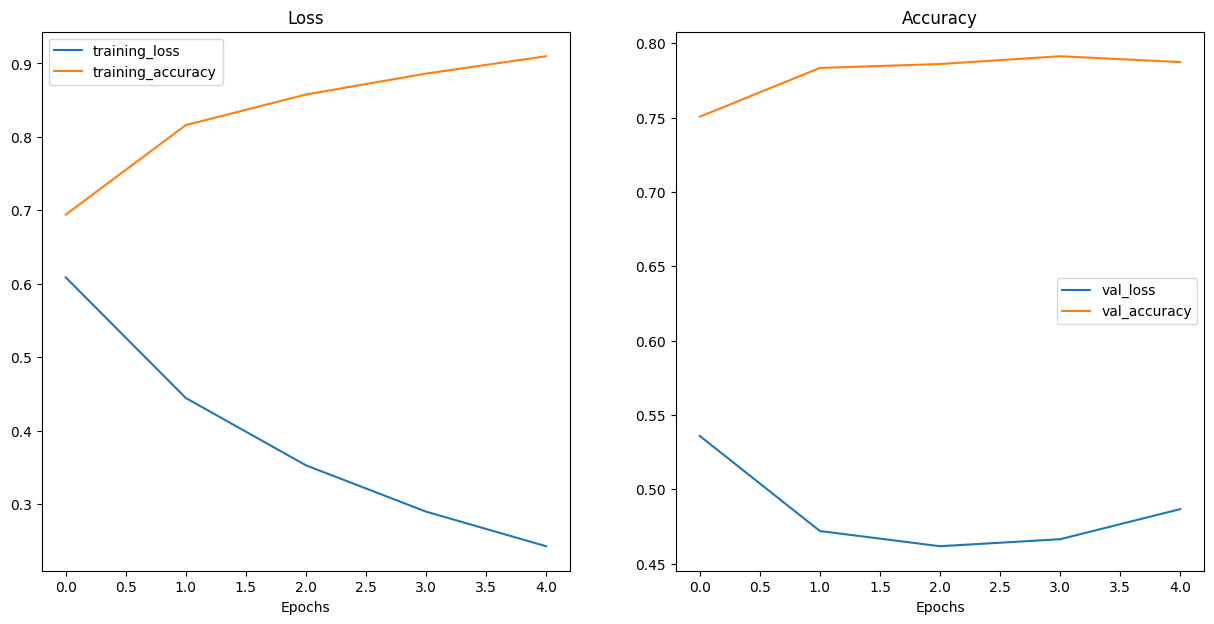

In [40]:
plot_loss_curves(history_1)

In [41]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7825 - loss: 0.5211 


[0.4867021143436432, 0.787401556968689]

In [42]:
embedding.weights

[<KerasVariable shape=(10000, 128), dtype=float32, path=embedding_1/embeddings>]

In [43]:
embed_weight = model_1.get_layer("embedding_1").get_weights()
embed_weight[0].shape

(10000, 128)

In [44]:
# Make predictions
model_1_preds = model_1.predict(val_sentences)
model_1_preds[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


array([[0.30261043],
       [0.67361677],
       [0.99769086],
       [0.10250784],
       [0.09861051],
       [0.9293277 ],
       [0.9237646 ],
       [0.9909654 ],
       [0.9574819 ],
       [0.25207534]], dtype=float32)

In [45]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_preds))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [46]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 0.7874015748031497,
 'precision': 0.7942180127180873,
 'recall': 0.7874015748031497,
 'f1': 0.7838012115396069}

In [47]:
# Visualizing learned embeddings
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [48]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

## Model 2: LSTM

In [49]:
from tensorflow.keras.layers import TextVectorization

max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [50]:
text_vectorizer.adapt(train_sentences)

In [51]:
tf.random.set_seed(42)

model_2_embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                              output_dim = 128,
                                              embeddings_initializer = "uniform",
                                              input_length = max_length,
                                              name = "embedding_2")

# Create LSTM Model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
print(x.shape)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15)
(None, 15, 128)
(None, 64)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
# Get the Summary of the model
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_2                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
def create_model_check_pt(model_name):
  model_check_pt = tf.keras.callbacks.ModelCheckpoint("./data/" + model_name,
                                  monitor='val_loss',
                                  verbose=0,
                                  save_best_only=False,
                                  save_weights_only=False,
                                  mode='auto',
                                  save_freq='epoch',
                                  initial_value_threshold=None)
  return model_check_pt

In [55]:
# Fit the model_2
history_2 = model_2.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_model_check_pt("model_2.keras")])

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.6779 - loss: 0.5798 - val_accuracy: 0.7808 - val_loss: 0.4569
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8644 - loss: 0.3301 - val_accuracy: 0.7598 - val_loss: 0.5072
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9165 - loss: 0.2275 - val_accuracy: 0.7493 - val_loss: 0.6493
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9443 - loss: 0.1561 - val_accuracy: 0.7572 - val_loss: 0.7763
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9652 - loss: 0.1061 - val_accuracy: 0.7690 - val_loss: 0.6867


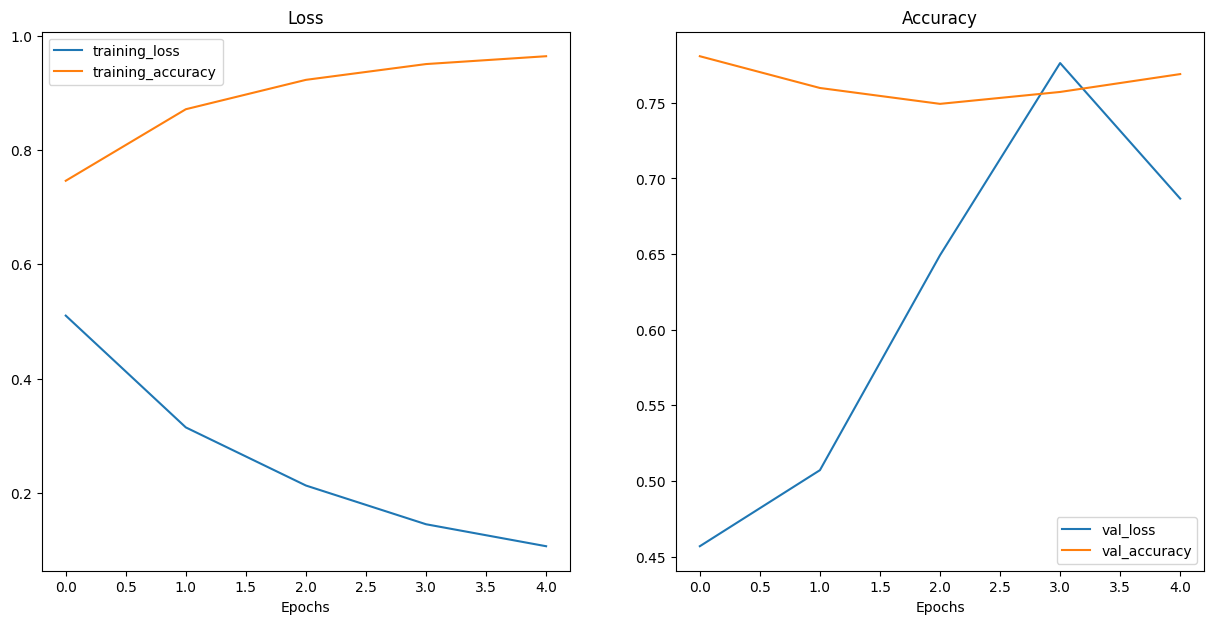

In [56]:
plot_loss_curves(history_2)

In [57]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


array([[0.05156222],
       [0.9344808 ],
       [0.997901  ],
       [0.06436692],
       [0.00453673],
       [0.99677145],
       [0.7275513 ],
       [0.99963814],
       [0.99807316],
       [0.30688685]], dtype=float32)

In [58]:
model_2_pred_probs = tf.squeeze(tf.round(model_2_pred_probs))
model_2_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [59]:
model_2_results = calculate_results(val_labels, model_2_pred_probs)
model_2_results

{'accuracy': 0.7690288713910761,
 'precision': 0.7717390408616506,
 'recall': 0.7690288713910761,
 'f1': 0.766385677090764}

## Model 3: GRU

In [60]:
# Set the random seed
tf.random.set_seed(42)

model_3_embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                              output_dim = 128,
                                              embeddings_initializer = "uniform",
                                              input_length = max_length,
                                              name = "embedding_3")

# Build an RNN using the GRU Cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
print(x.shape)
x = model_3_embedding(x)
print(x.shape)
# x = layers.GRU(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

(None, 15)
(None, 15, 128)
(None, 64)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [61]:
# Get the summary of the model_3
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_2                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Fit the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
history_3 = model_3.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_model_check_pt("model_3.keras")])

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6402 - loss: 0.6137 - val_accuracy: 0.7808 - val_loss: 0.4592
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8579 - loss: 0.3435 - val_accuracy: 0.7703 - val_loss: 0.5137
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9081 - loss: 0.2393 - val_accuracy: 0.7625 - val_loss: 0.5557
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9404 - loss: 0.1668 - val_accuracy: 0.7703 - val_loss: 0.5774
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9547 - loss: 0.1403 - val_accuracy: 0.7690 - val_loss: 0.6445


In [64]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


array([[0.1049177 ],
       [0.9133546 ],
       [0.9940143 ],
       [0.07733621],
       [0.01374894],
       [0.9835695 ],
       [0.46767485],
       [0.9966222 ],
       [0.9954714 ],
       [0.89832   ]], dtype=float32)

In [65]:
model_3_pred_probs = tf.squeeze(tf.round(model_3_pred_probs))
model_3_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [66]:
model_3_results = calculate_results(val_labels, model_3_pred_probs)
model_3_results

{'accuracy': 0.7690288713910761,
 'precision': 0.7706028054440214,
 'recall': 0.7690288713910761,
 'f1': 0.7669342344352704}

## Model 4: Bi-directional RNN Model

In [67]:
# Set the random seed
tf.random.set_seed(42)

model_4_embeddings = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                               output_dim = 128,
                                               embeddings_initializer="uniform",
                                               input_length = max_length,
                                               name = "embedding_4")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [68]:
# Build a Bidirectional RNN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embeddings(x)
x = layers.Bidirectional(layers.LSTM(64,))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [69]:
# Compile the model
model_4.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [70]:
# Get a summary of our Bidirectional model
model_4.summary()

Model: "model_4_bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_2                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history_4 = model_4.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_model_check_pt("model_4.keras")])

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.6769 - loss: 0.5794 - val_accuracy: 0.7822 - val_loss: 0.4598
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8657 - loss: 0.3261 - val_accuracy: 0.7690 - val_loss: 0.5234
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9195 - loss: 0.2164 - val_accuracy: 0.7572 - val_loss: 0.6593
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9560 - loss: 0.1293 - val_accuracy: 0.7559 - val_loss: 0.6746
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9611 - loss: 0.1219 - val_accuracy: 0.7572 - val_loss: 0.6987


In [72]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


array([[0.04883835],
       [0.8908627 ],
       [0.99888843],
       [0.04106669],
       [0.00433817],
       [0.9828286 ],
       [0.13881493],
       [0.9996626 ],
       [0.9984579 ],
       [0.51605713]], dtype=float32)

In [73]:
model_4_pred_probs = tf.squeeze(tf.round(model_4_pred_probs))
model_4_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [74]:
# Calcualate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_pred_probs)

In [75]:
model_4_results

{'accuracy': 0.7572178477690289,
 'precision': 0.7603099308263768,
 'recall': 0.7572178477690289,
 'f1': 0.7540488952688414}

## Model 5: Conv1D

In [76]:
embedding_test = embedding(text_vectorizer(["Make in India"]))
conv_1d = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = tf.keras.layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [77]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.00432797, -0.04262029,  0.0185807 , ...,  0.01859381,
           0.06470209,  0.01697102],
         [-0.04918822,  0.06053616,  0.12919028, ...,  0.01043325,
          -0.08950235,  0.06017055],
         [-0.0609914 ,  0.06025535,  0.12013621, ...,  0.02517603,
          -0.02642419,  0.10319771],
         ...,
         [-0.02451599, -0.05019816, -0.02958721, ..., -0.04915319,
           0.0376977 ,  0.00880838],
         [-0.02451599, -0.05019816, -0.02958721, ..., -0.04915319,
           0.0376977 ,  0.00880838],
         [-0.02451599, -0.05019816, -0.02958721, ..., -0.04915319,
           0.0376977 ,  0.00880838]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.        , 0.05681749, 0.        , 0.03043344, 0.        ,
          0.        , 0.00982846, 0.0672055 , 0.        , 0.02742369,
          0.10661563, 0.06142505, 0.        , 0.10445965, 0.        ,
          0.15074137, 0.

In [78]:
# Set the random seed
tf.random.set_seed(42)

model_5_embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                              output_dim = 128,
                                              embeddings_initializer = "uniform",
                                              input_length = max_length,
                                              name = "embedding_5")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [79]:
# Create 1D Convolutional layer to model sequence
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [80]:
# Compile the model
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [81]:
# Get the summary
model_5.summary()

Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_2                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 11, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321,089 (5.04 MB)

 Trainable params: 1,321,089 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_model_check_pt("model_5.keras")])

Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6531 - loss: 0.6221 - val_accuracy: 0.7835 - val_loss: 0.4660
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8523 - loss: 0.3635 - val_accuracy: 0.7782 - val_loss: 0.4853
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9146 - loss: 0.2288 - val_accuracy: 0.7848 - val_loss: 0.5520
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9497 - loss: 0.1415 - val_accuracy: 0.7848 - val_loss: 0.6313
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9696 - loss: 0.0956 - val_accuracy: 0.7835 - val_loss: 0.6934


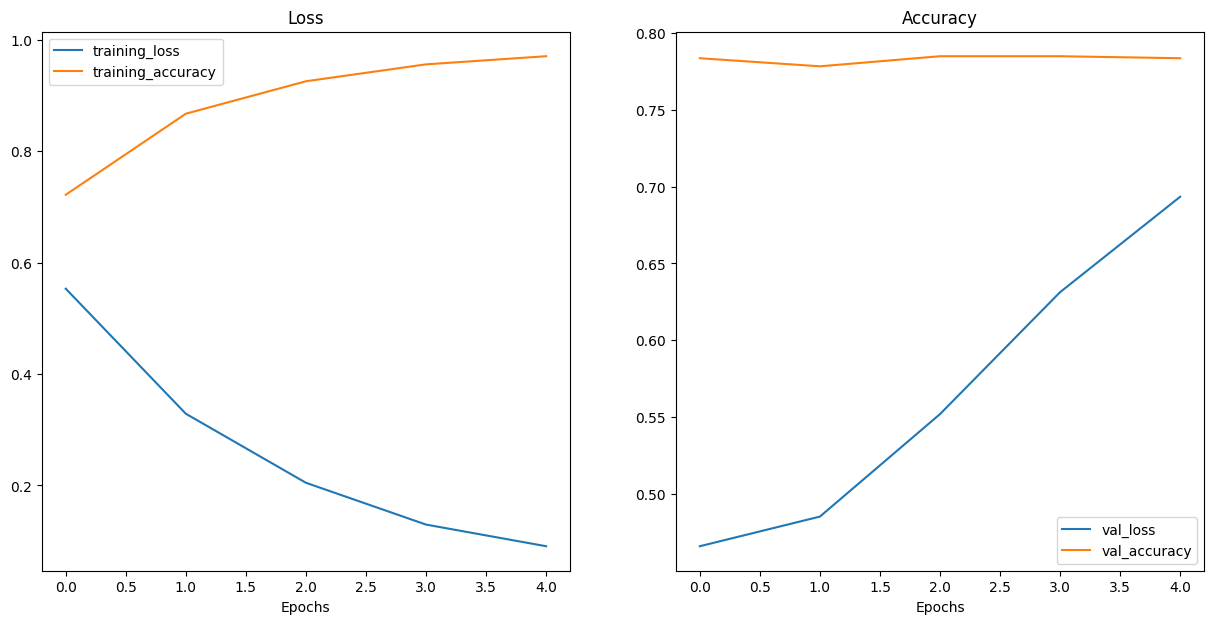

In [83]:
plot_loss_curves(model_5_history)

In [84]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_results(val_labels, model_5_pred_probs)
model_5_results

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


{'accuracy': 0.7834645669291339,
 'precision': 0.7888731352165597,
 'recall': 0.7834645669291339,
 'f1': 0.780192419920975}

## Pre-trained model

In [85]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[ 0.01664466 -0.05609326 -0.03472929 -0.01290384  0.04508746 -0.04135302
 -0.03754725 -0.05895521 -0.01348031  0.0239853   0.03152377 -0.07395998
 -0.00477862  0.0385538   0.07053438 -0.06307168  0.02046808 -0.03817149
 -0.01033931 -0.01501729 -0.05543564 -0.00340833  0.03888854 -0.01188536
  0.02052457 -0.01390118 -0.01490298 -0.04399249  0.01813943  0.03508951
 -0.0136664   0.02434982 -0.01769268 -0.00670574 -0.06756052  0.04056968
  0.02997426 -0.0483025  -0.03755558  0.01531089 -0.00450522  0.01751466
 -0.05969479  0.02003885  0.03010011  0.07364915 -0.08194125 -0.00745079
  0.01600788  0.01300682], shape=(50,), dtype=float32)


In [86]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [87]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [88]:
tf.random.set_seed(42)
import tf_keras
model_6 = tf_keras.Sequential([
    sentence_encoder_layer,
    tf_keras.layers.Dense(64, activation="relu"),
    tf_keras.layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

In [89]:
model_6.compile(loss=tf_keras.losses.BinaryCrossentropy(),
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [90]:
history_6 = model_6.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 7s 16ms/step - loss: 0.5056 - accuracy: 0.7872 - val_loss: 0.4471 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4149 - accuracy: 0.8145 - val_loss: 0.4359 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4000 - accuracy: 0.8218 - val_loss: 0.4317 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3927 - accuracy: 0.8264 - val_loss: 0.4275 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3866 - accuracy: 0.8297 - val_loss: 0.4296 - val_accuracy: 0.8150


In [91]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs = tf.squeeze(tf.round(model_6_pred_probs))
model_6_results = calculate_results(val_labels, model_6_pred_probs)
model_6_results

24/24 [==============================] - 1s 10ms/step


{'accuracy': 0.8149606299212598,
 'precision': 0.8172549323109193,
 'recall': 0.8149606299212598,
 'f1': 0.8134357776936025}

## Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [92]:
import numpy as np
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [93]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [94]:
import pandas as pd
pd.Series(train_labels_10_percent).value_counts()

,count
0,415
1,271


In [95]:
# Clone model_6 but reset weights
model_7 = tf_keras.models.clone_model(model_6)
model_7.compile(loss=tf_keras.losses.BinaryCrossentropy(),
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

In [96]:
history_7 = model_7.fit(train_sentences_10_percent,
                        train_labels_10_percent,
                        epochs=5,
                        validation_data=(val_sentences, val_labels))

Epoch 1/5
22/22 [==============================] - 5s 62ms/step - loss: 0.6697 - accuracy: 0.6822 - val_loss: 0.6517 - val_accuracy: 0.7139
Epoch 2/5
22/22 [==============================] - 1s 23ms/step - loss: 0.5998 - accuracy: 0.8017 - val_loss: 0.5940 - val_accuracy: 0.7467
Epoch 3/5
22/22 [==============================] - 1s 24ms/step - loss: 0.5238 - accuracy: 0.8192 - val_loss: 0.5401 - val_accuracy: 0.7690
Epoch 4/5
22/22 [==============================] - 1s 23ms/step - loss: 0.4595 - accuracy: 0.8324 - val_loss: 0.5079 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4157 - accuracy: 0.8397 - val_loss: 0.4902 - val_accuracy: 0.7769


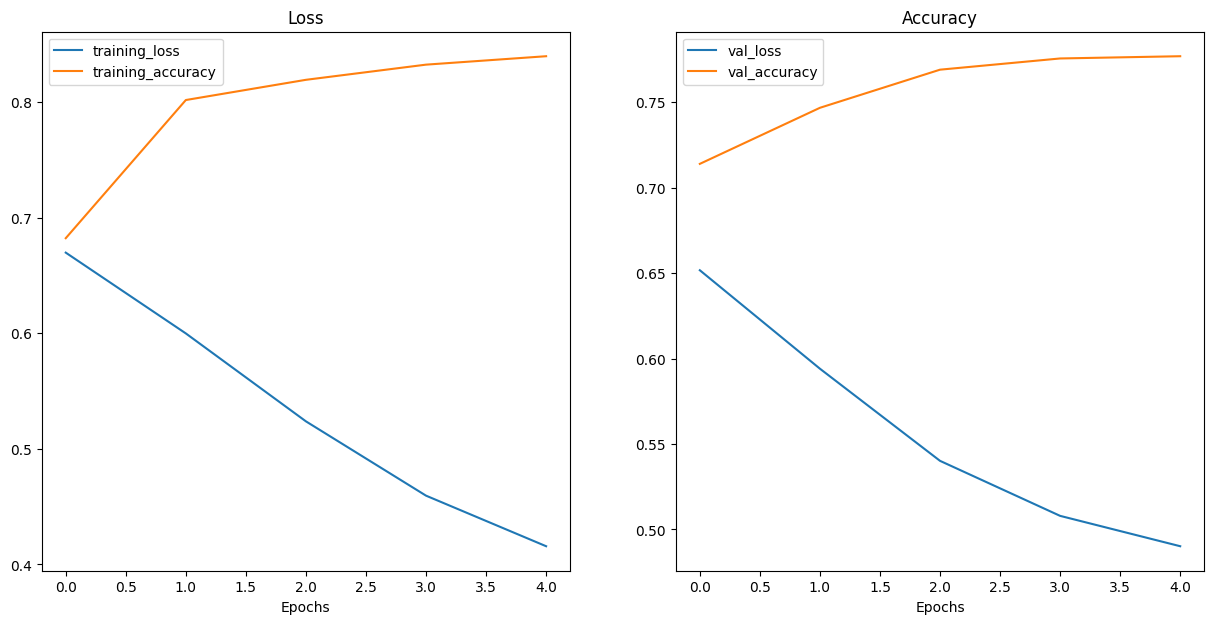

In [97]:
plot_loss_curves(history_7)

In [98]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs = tf.squeeze(tf.round(model_7_pred_probs))
model_7_results = calculate_results(val_labels, model_7_pred_probs)
model_7_results

24/24 [==============================] - 1s 11ms/step


{'accuracy': 0.7769028871391076,
 'precision': 0.7822241302284023,
 'recall': 0.7769028871391076,
 'f1': 0.7734519762210931}

In [99]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.787402,0.794218,0.787402,0.783801
lstm,0.769029,0.771739,0.769029,0.766386
gru,0.769029,0.770603,0.769029,0.766934
bidirectional,0.757218,0.760310,0.757218,0.754049
conv1d,0.783465,0.788873,0.783465,0.780192
tf_hub_sentence_encoder,0.814961,0.817255,0.814961,0.813436
tf_hub_10_percent_data,0.776903,0.782224,0.776903,0.773452


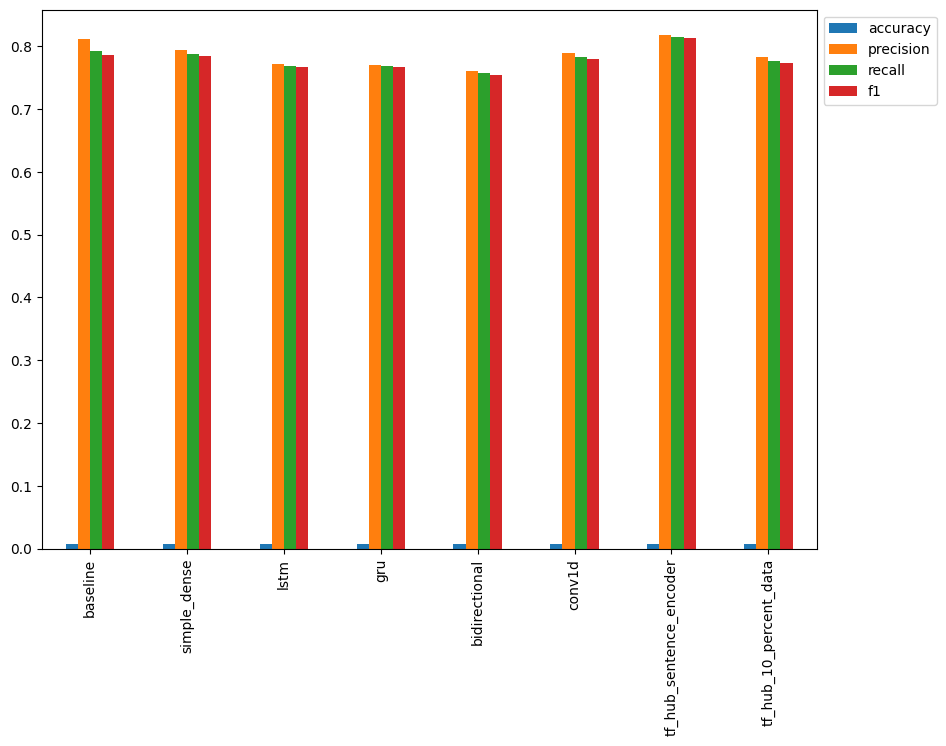

In [100]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

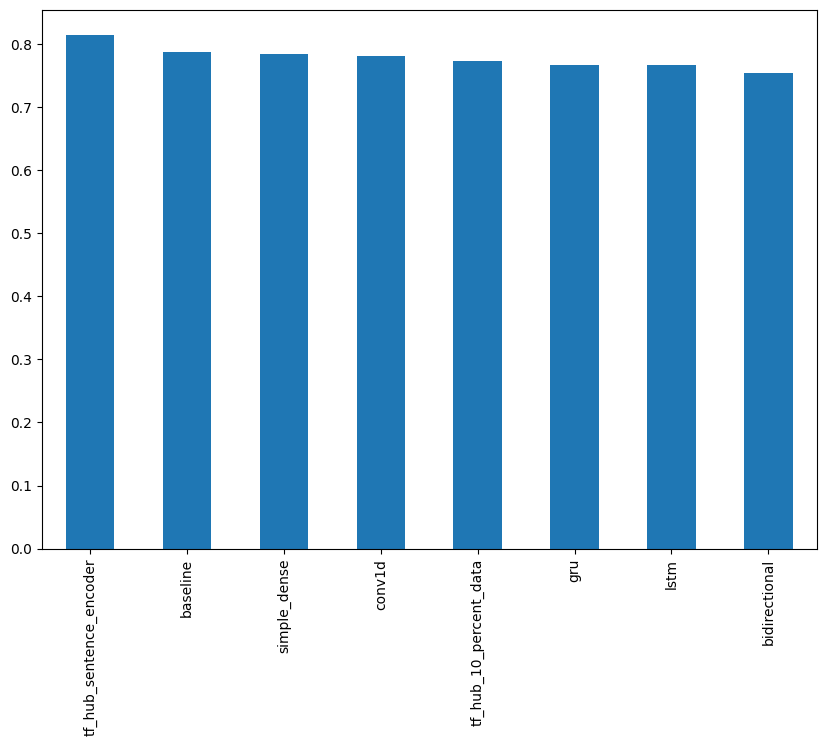

In [101]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [102]:
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [103]:
model = tf_keras.models.load_model("model_6.h5",
                                   custom_objects={"KerasLayer": hub.KerasLayer})

In [104]:
model.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [105]:
model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 18ms/step - loss: 0.4296 - accuracy: 0.8150


[0.4296426475048065, 0.8149606585502625]

In [106]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [107]:
import tf_keras
model = tf_keras.models.load_model("model_6_SavedModel_format")

In [108]:
model.summary()
model.evaluate(val_sentences, val_labels)

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________
24/24 [==============================] - 2s 20ms/step - loss: 0.4296 - accuracy: 0.8150


[0.4296426475048065, 0.8149606585502625]

In [118]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs = model_6_pred_probs.flatten()
model_6_pred = tf.squeeze(tf.round(model_6_pred_probs))

24/24 [==============================] - 0s 18ms/step


## Finding the most wrong predictions

In [119]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pred,
                       "pred_prob": model_6_pred_probs})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.147423
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.753668
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.987684
3,@camilacabello97 Internally and externally scr...,1,0.0,0.193354
4,Radiation emergency #preparedness starts with ...,1,1.0,0.732039


In [121]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.909428
759,FedEx will no longer transport bioterror patho...,0,1.0,0.859739
628,@noah_anyname That's where the concentration c...,0,1.0,0.854420
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.839675
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.839555
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.819103
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.801943
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.793666
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.791816
567,@RebeccaforReal accepts Wisconsin Emergency Re...,0,1.0,0.761791


In [122]:
len(most_wrong)

141

* 0 = Not a real diaster Tweet
* 1 = Real diaster Tweet

In [123]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9094282388687134
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8597386479377747
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8544195294380188
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8396748900413513
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8395550847053528
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8191030621528625
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Pr

In [124]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06356911361217499
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.05892905965447426
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.05597924441099167
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.05294390022754669
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.04985186830163002
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.04634430631995201
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.04108675196766853
Text:
Reddit Will Now Quar

## Making Predictions on the test dataset

In [125]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 86ms/step
Pred: 1, Prob: 0.6128234267234802
Text:
12000 Nigerian refugees repatriated from Cameroon http://t.co/LeLYa0vDOg read /////

----

1/1 [==============================] - 0s 81ms/step
Pred: 1, Prob: 0.6799005270004272
Text:
The EFAK would be designed for building occupants once they evacuate and report to their evacuation assembly sites

----

1/1 [==============================] - 0s 64ms/step
Pred: 1, Prob: 0.945573091506958
Text:
Special Weather Statement issued August 05 at 10:40PM EDT by NWS: ...STRONG THUNDERSTORM WILL IMPACT PORTIONS ... http://t.co/ulqeR1yTpX

----

1/1 [==============================] - 0s 69ms/step
Pred: 0, Prob: 0.08644403517246246
Text:
death is the only certainty in life

----

1/1 [==============================] - 0s 94ms/step
Pred: 0, Prob: 0.05841980502009392
Text:
Success is not final failure is not fatal.It is the courage to continue that counts - http://t.co/gRTHlAACfV

----

1/1 [==================

In [126]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [127]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [128]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 72ms/step
Pred: 0.0 (not real disaster) Prob: 0.04593776538968086
Text:
Life like an ensemble: take the best choices from others and make your own


In [129]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [130]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 1s 21ms/step


(0.7591125489998376, 0.0009962106942255087)

In [131]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.10982510200119577, 0.00014412743044776348)

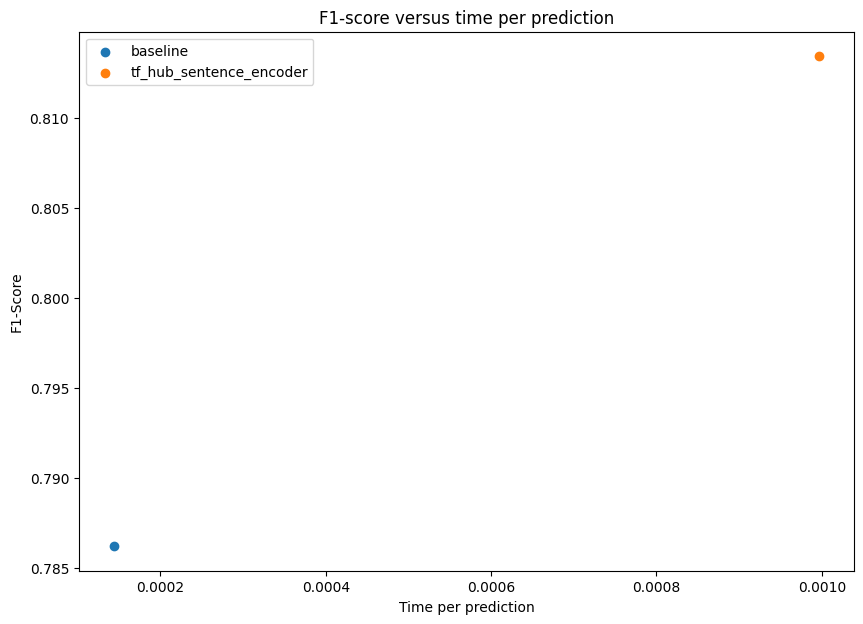

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");